In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool

mi.set_variant('cuda_ad_rgb')

In [2]:
# !python3 /home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/generate_cbox.py 4


In [3]:
from radiosity_sh import RadianceCacheMiSH
from radiosity_sh import compute_loss as compute_loss_sh

# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox.xml")
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox-rgb.xml")
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/matpreview/matpreview.xml")

sh_order = 3
radiance_cache = RadianceCacheMiSH(scene, sh_order, fit_Nquad=128, fit_spp=64)

Fitting spherical harmonics to scene...


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]

Fitting complete.


In [4]:
# from sh_fitting import get_sh_count
# rc = radiance_cache
# meshes = [shape for shape in rc.scene.shapes() if shape.is_mesh()]

# mesh_count = len(meshes)
# vtx_counts = UInt([mesh.vertex_count() for mesh in meshes])
# scene_Nv = dr.sum(vtx_counts)[0]
# start_indices = dr.prefix_sum(vtx_counts)
# E_scene = dr.zeros(Float, scene_Nv)

# for mesh_idx, mesh in enumerate(meshes):
#     # Compute the energy emitted by each vertex of the mesh as the sum of the squared SH coefficients
#     E_mesh = dr.zeros(Float, mesh.vertex_count())
#     for sh_idx in range(get_sh_count(rc.order)):
#         coeffs = dr.unravel(mi.Color3f, mesh.attribute_buffer(f"vertex_Lo_coeffs_{sh_idx}"))
#         E_mesh += dr.squared_norm(coeffs)
#     # Store the mesh vertices' energy values in the scene-level energy-per-vertex array
#     start_idx = start_indices[mesh_idx]
#     end_idx = start_indices[mesh_idx + 1] if mesh_idx < mesh_count - 1 else scene_Nv
#     dr.scatter_add(E_scene, E_mesh, dr.arange(UInt, start_idx, end_idx))

# import numpy as np
# # DEBUG: the scene-level array `E_scene` should simply be the concatenation of the meshes' energy-per-vertex arrays
# E_scene_np = []
# for mesh_idx, mesh in enumerate(meshes):
#     E_mesh = dr.zeros(Float, mesh.vertex_count())
#     for sh_idx in range(get_sh_count(rc.order)):
#         coeffs = dr.unravel(mi.Color3f, mesh.attribute_buffer(f"vertex_Lo_coeffs_{sh_idx}"))
#         E_mesh += dr.squared_norm(coeffs)
#     E_scene_np.append(E_mesh.numpy())

# E_scene_np = np.concatenate(E_scene_np)
# assert np.allclose(E_scene_np, E_scene.numpy()), "Scene vertex array is not correct!"

# pmf = mi.DiscreteDistribution(E_scene)


# from radiosity_sh import EnergyPMF

# pmf = EnergyPMF(radiance_cache)


# sample1 = Float([0.5, 0.9999, 0.01, 0.1])
# global_vtx_idx, pdf = pmf.pmf.sample_pmf(sample1)
# dtype = type(pmf.mesh_end_idxs)
# mesh_count = len(pmf.mesh_end_idxs)
# mesh_idxs = dr.binary_search(0, mesh_count, lambda index: dr.gather(dtype, pmf.mesh_end_idxs, index) <= global_vtx_idx)
# print(global_vtx_idx)
# print(mesh_idxs)
# print(dr.gather(dtype, pmf.mesh_start_idxs, mesh_idxs))
# local_vtx_idx = global_vtx_idx - dr.gather(dtype, pmf.mesh_start_idxs, mesh_idxs)
# print(local_vtx_idx)

# meshes = dr.gather(mi.MeshPtr, scene.shapes_dr(), mesh_idxs)
# p, n = meshes.vertex_position(local_vtx_idx), meshes.vertex_normal(local_vtx_idx)
# ps = dr.zeros(mi.PositionSample3f, dr.width(sample1))
# ps.p, ps.n = p, n
# ps.delta = False
# ps.pdf = pdf
# weight = dr.select(ps.pdf > 0.0, dr.rcp(ps.pdf), Float(0.0))
# ps

In [5]:
from radiosity_sh import SceneSurfaceSampler

scene_sampler = SceneSurfaceSampler(scene)

In [6]:
from radiosity_rt import RadianceCacheMiRT
from radiosity_rt import compute_loss as compute_loss_rt

radiance_cache_exact = RadianceCacheMiRT(scene, 256, 128)

In [7]:
colors = {
    'white': [0.9, 0.7, 0.6],
    'box': [0.5, 0.3, 0.9],
    'red': [0.6, 0.1, 0.1],
    'green': [0.1, 0.4, 0.1],
    'light': [0.9, 0.7, 0.7]
}

mesh_materials = ['light', 'white', 'white', 'white', 'green', 'red', 'box', 'box']

In [8]:
from vertex_bsdf import Principled, Diffuse

bsdf_train = Principled(specular=0.0)   # TODO: should `specular` also be a trainable parameter?

for mesh_idx, mesh in enumerate(scene.shapes()):
    if not(mesh.is_mesh()):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5], m_roughness = 0.0, m_metallic = 0.0)


# for idx, (mesh, material) in enumerate(zip(scene.shapes(), mesh_materials)):
#     if not(mesh.is_mesh()):
#         continue
#     bsdf_train.initialize_mesh_attributes(mesh, colors[material], m_roughness = 0.0, m_metallic = 0.0)

# TODO
bsdf_train = Diffuse()

In [9]:
NUM_GEO_SAMPLES = 1 << 12 # 1 << 14
NUM_WI_DIRECTIONS = 256 << 0

In [10]:
# bsdf1 = Diffuse()
# bsdf2 = Principled(False, specular=0.0)

# N = 4
# sampler_rt = mi.load_dict({'type' : 'independent'})
# sampler_rt.seed(3, wavefront_size=N)
# si = scene_sampler.sample(N, sampler_rt, 4)[0]
# wi = mi.warp.square_to_cosine_hemisphere(sampler_rt.next_2d())
# sample1 = sampler_rt.next_1d()
# sample2 = sampler_rt.next_2d()

# bsdf_ref = si.shape.bsdf() 
# print("eval():", dr.allclose(
#     bsdf1.eval(mi.BSDFContext(), si, wi),
#     bsdf_ref.eval(mi.BSDFContext(), si, wi)))

# print("pdf():", dr.allclose(
#     bsdf1.pdf(mi.BSDFContext(), si, wi),
#     bsdf_ref.pdf(mi.BSDFContext(), si, wi)))

# print("sample().color:", dr.allclose(
#     bsdf1.sample(mi.BSDFContext(), si, sample1, sample2)[1],
#     bsdf_ref.sample(mi.BSDFContext(), si, sample1, sample2)[1]))
# print("sample().bs.wo:", dr.allclose(
#     bsdf1.sample(mi.BSDFContext(), si, sample1, sample2)[0].wo,
#     bsdf_ref.sample(mi.BSDFContext(), si, sample1, sample2)[0].wo))
# print("sample().bs.pdf:", dr.allclose(
#     bsdf1.sample(mi.BSDFContext(), si, sample1, sample2)[0].pdf,
#     bsdf_ref.sample(mi.BSDFContext(), si, sample1, sample2)[0].pdf))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.7265291].


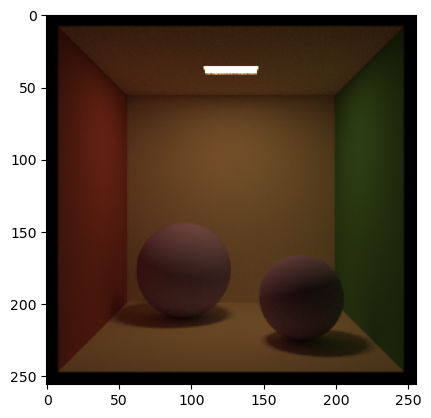

In [11]:
import matplotlib.pyplot as plt
plt.imshow(mi.render(scene) ** (1 / 2.2))

In [12]:
# from vertex_bsdf import visualize_textures

# visualize_textures(scene)

In [13]:
from time import time

params = mi.traverse(scene)
# keys = [key for key in params.keys() if "vertex_bsdf" in key]
keys = [key for key in params.keys() if "vertex_bsdf_base_color" in key]    # TODO
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(50):
    time1 = time()

    # Evaluate the objective function for the current BSDF params
    # loss = compute_loss_sh(scene_sampler, radiance_cache, bsdf_train, 
    #     NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)
    loss = compute_loss_rt(scene_sampler, radiance_cache_exact, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

jit_flush_malloc_cache(): Dr.Jit exhausted the available memory and had to flush its allocation cache to free up additional memory. This is an expensive operation and will have a negative effect on performance. You may want to change your computation so that it uses less memory. This warning will only be displayed once.


Iteration 001 [0.683389]: Loss = [0.00133331]
Iteration 002 [0.495023]: Loss = [0.00127302]
Iteration 003 [0.489931]: Loss = [0.00106239]
Iteration 004 [0.489727]: Loss = [0.00105464]
Iteration 005 [0.490900]: Loss = [0.000924747]
Iteration 006 [0.492138]: Loss = [0.000919349]
Iteration 007 [0.486228]: Loss = [0.000850793]
Iteration 008 [0.490346]: Loss = [0.000807218]
Iteration 009 [0.488032]: Loss = [0.00077892]
Iteration 010 [0.489131]: Loss = [0.000729455]
Iteration 011 [0.485406]: Loss = [0.0560611]
Iteration 012 [0.486682]: Loss = [0.00073882]
Iteration 013 [0.486121]: Loss = [0.000763333]
Iteration 014 [0.486508]: Loss = [0.000828411]
Iteration 015 [0.489284]: Loss = [0.000827229]
Iteration 016 [0.490977]: Loss = [0.000846277]
Iteration 017 [0.496932]: Loss = [0.000833152]
Iteration 018 [0.492886]: Loss = [0.000782577]
Iteration 019 [0.500175]: Loss = [0.000745902]
Iteration 020 [0.500548]: Loss = [0.000779018]
Iteration 021 [0.497875]: Loss = [0.000762934]
Iteration 022 [0.4977

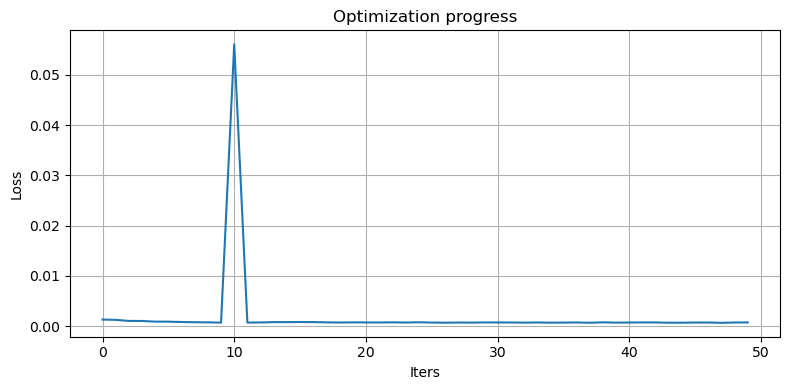

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()

In [16]:
# si = dr.zeros(mi.SurfaceInteraction3f)
# shape_idx = 4
# vtx_idx = 101
# mesh = scene.shapes()[shape_idx]
# si = dr.zeros(mi.SurfaceInteraction3f)
# si.p = mesh.vertex_position(95)
# si.n = mesh.vertex_normal(95)
# si.sh_frame = mi.Frame3f(si.n)
# si.wi = mi.Vector3f([0],[0],[1])
# si.shape = mi.ShapePtr(mesh)
# si

In [17]:
from vertex_bsdf import visualize_textures

visualize_textures(scene)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120


In [18]:
# from sh_fitting import visualize_fit

# visualize_fit(scene, sh_order)